## point cloud 点云距离计算
- 汪星宇
- 2021年12月


在对点云配准结果等的分析中，经常需要计算 `点云距离`，常见的点云距离计算包括点云与点云、点云与面距离。

### 1. 点云与点云距离
基本的点云距离计算思路是
1. 对模型采样
2. 计算采样点云与待计算点云的距离，每个点与样本的最近距离

> 很明显，上述方法会引入一些问题，有可能会造成困扰。即模型采样的方式对点云距离计算结果存在影响，可以通过增加采样点数削弱这种影响，但这种误差是不会消除的。
>
> 此外，细密的点云采样给数据存储和计算带来了一定的负担，最终目标当然是简单且精准的几何计算方法。

In [1]:
import open3d as o3d
import numpy as np
import copy
import open3d_tutorial


def txt2PointCloud(path):
    """
    txt 到 点云
    :param path: 文件路径
    :return: pcd 点云文件
    """
    with open(path) as temp:
        points = temp.read()
        points = points.strip().split('\n')

        PointXYZ = []
        for i in points:
            PointXYZ.append([float(x) for x in i.split(' ')])

    temp = np.asarray(PointXYZ)
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(temp)
    return source

# 读取txt扫描数据文件 返回 pcd
sourcePath = "../data/pz.txt"
source = txt2PointCloud(sourcePath)

# 读取 mesh
targetPath = "../data/pz.STL"
mesh = o3d.io.read_triangle_mesh(targetPath)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


mesh采样的一般而言越多越好，以后可以进一步研究***采样密度与点云距离关系***

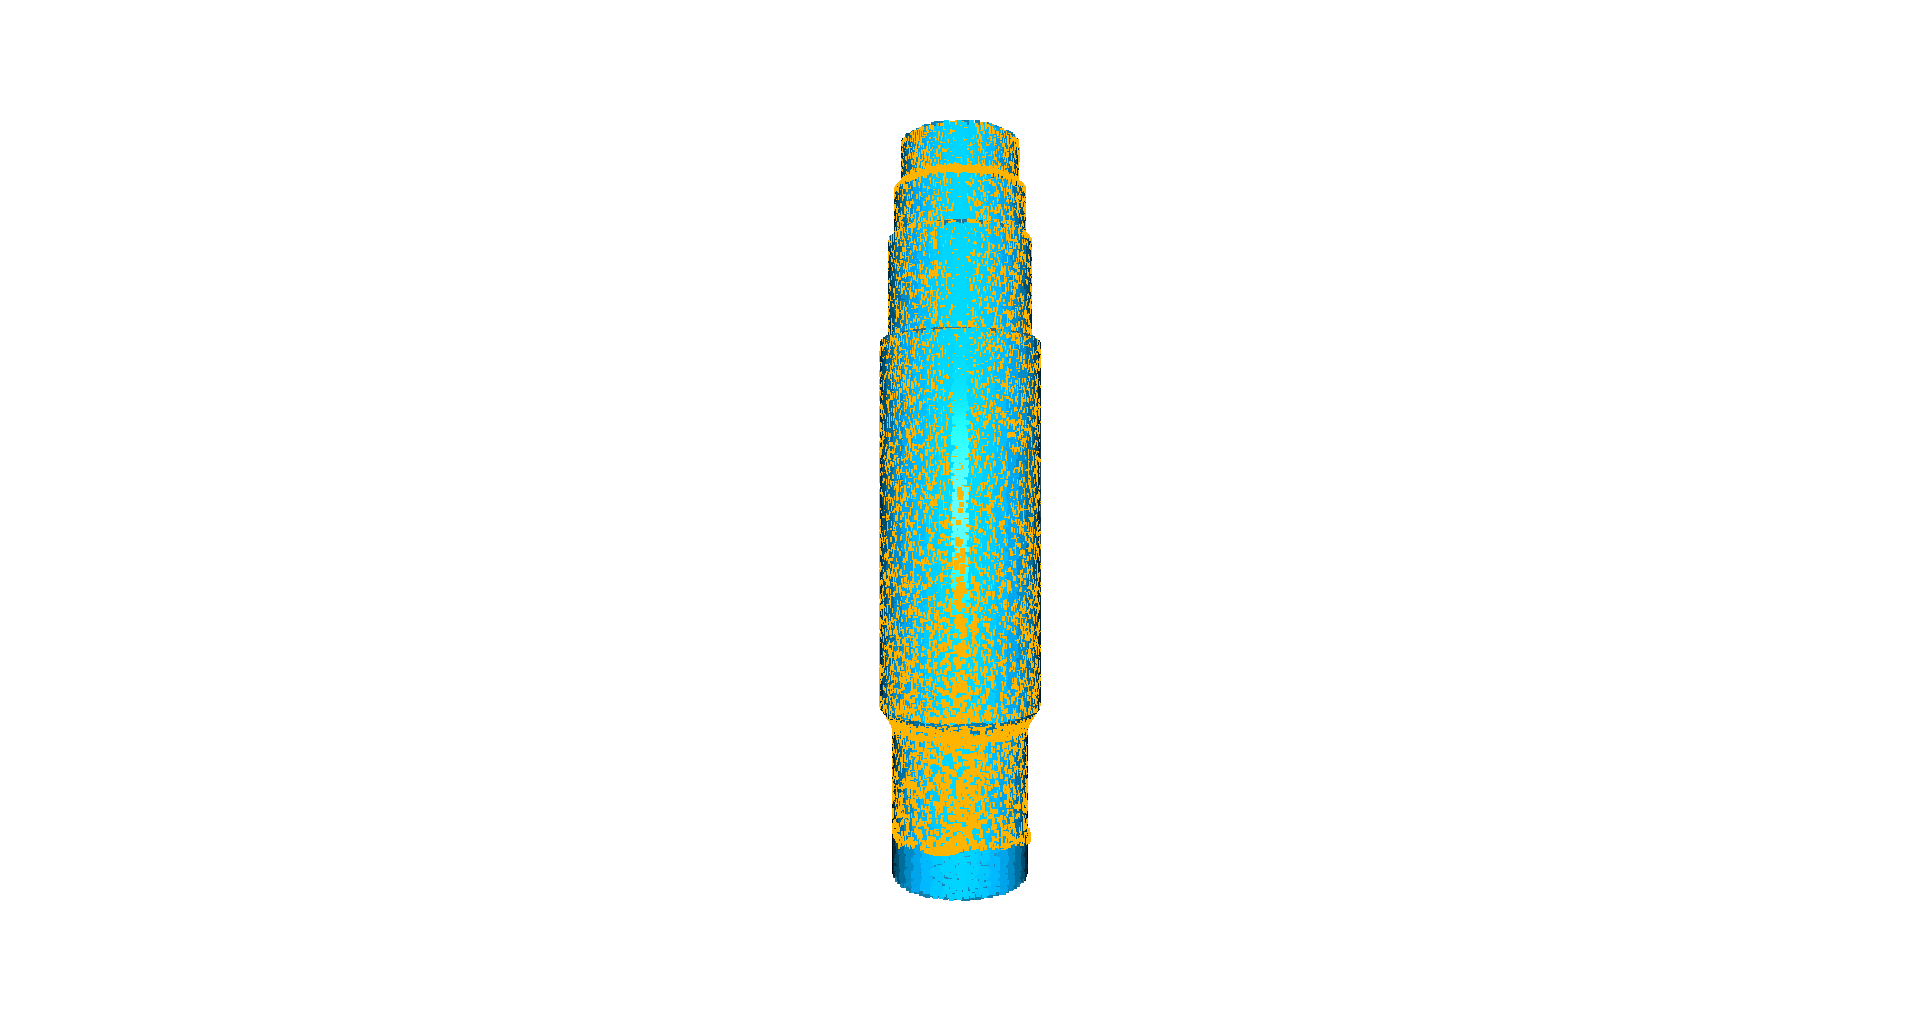

In [2]:
# mesh 采样生成 pcd
numbers_of_points = len(source.points)
target = mesh.sample_points_poisson_disk(number_of_points=numbers_of_points, init_factor=5)

# 预先计算好的配准矩阵
trans = np.array([[-9.99990451e-01,  2.12013173e-04,  4.36505397e-03,  9.24958639e+00],
                  [ 2.07372057e-04,  9.99999413e-01, -1.06366874e-03,  8.58288685e+01],
                  [-4.36527692e-03, -1.06275339e-03, -9.99989907e-01,  9.18186355e+00],
                  [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# 配准
source = source.transform(trans)

# 距离计算
dists = source.compute_point_cloud_distance(target)

#显示配准情况
source_temp = copy.deepcopy(source)
target_temp = copy.deepcopy(target)
source_temp.paint_uniform_color([1, 0.706, 0])
target_temp.paint_uniform_color([0, 0.651, 0.929])
o3d.visualization.draw_geometries([source_temp, target_temp])

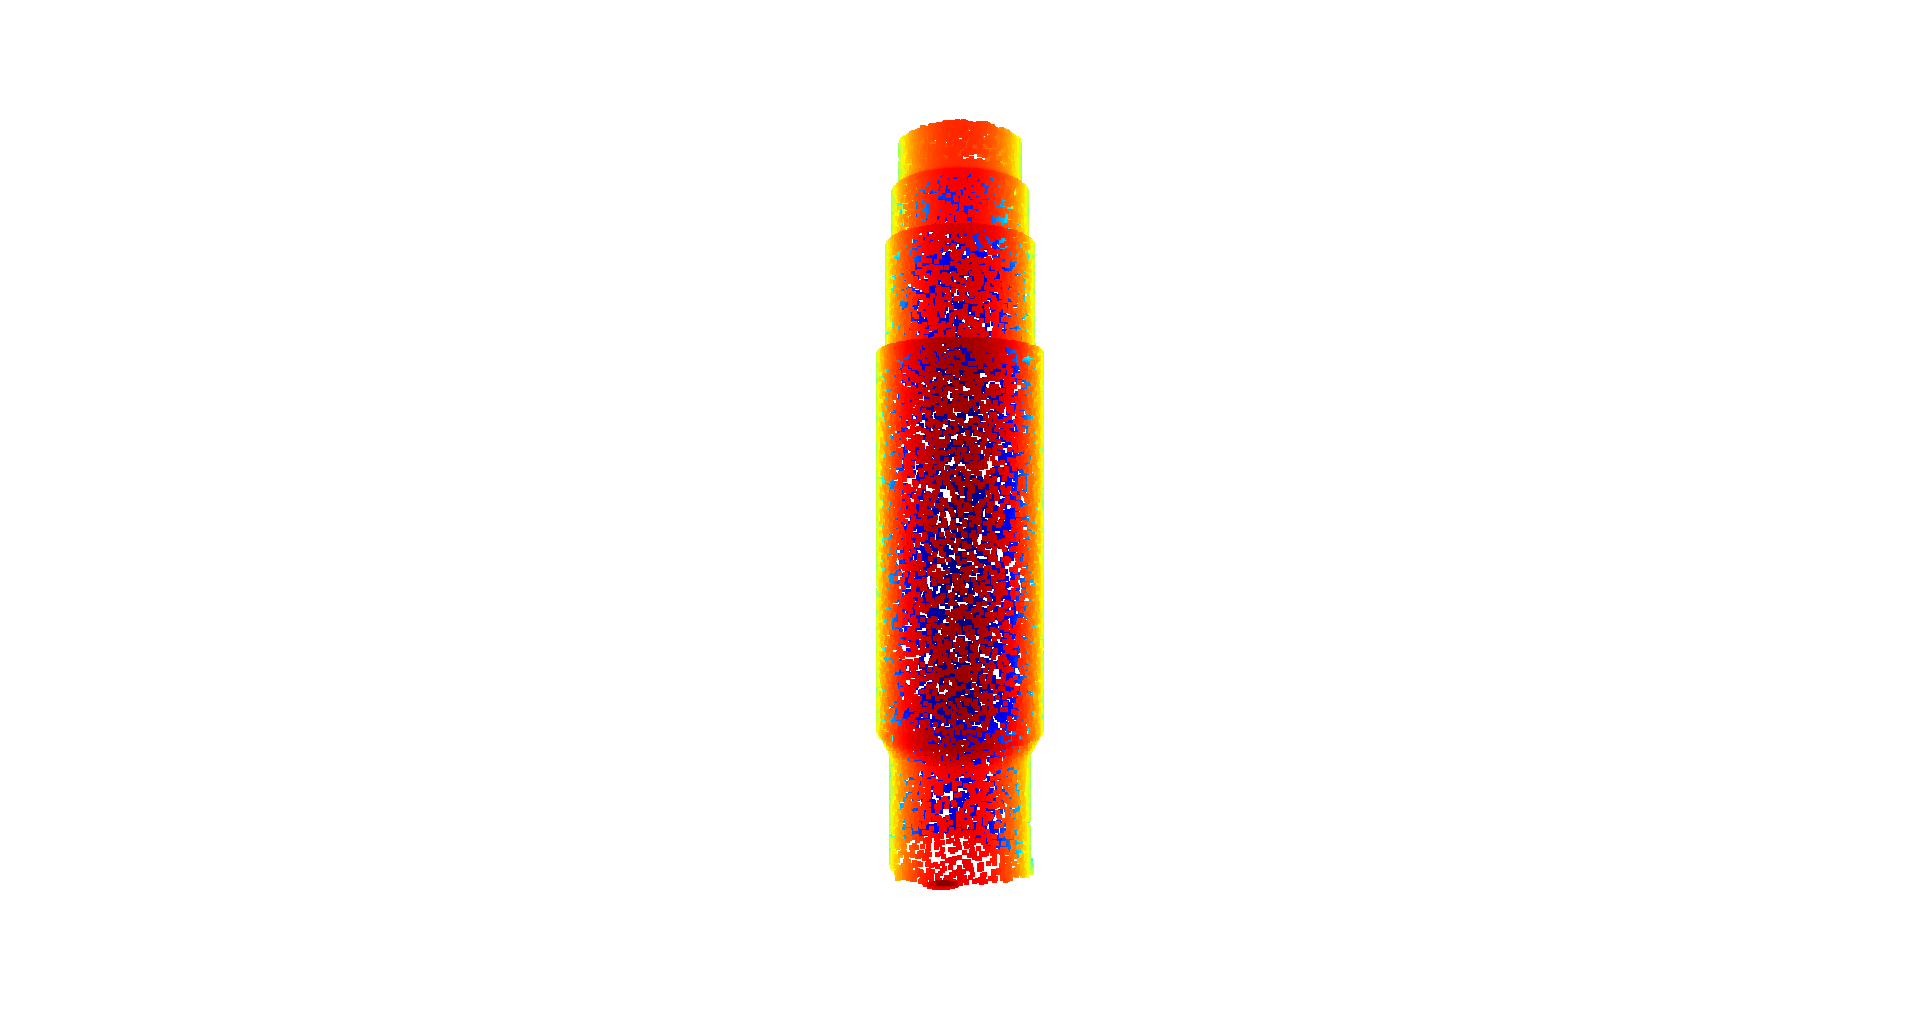

In [3]:
# 展示点云与点云距离
dists = np.asarray(dists)
# 配准展示距离 > n 的点
ind = np.where(dists > 0.1)[0]
pcd_without_chair = source.select_by_index(ind)
# pcd_without_chair.paint_uniform_color([1, 1, 0])
o3d.visualization.draw_geometries([pcd_without_chair])

### 2. 点云与mesh(平面)距离

在Open3D的[github issue](https://github.com/isl-org/Open3D/issues/1195)中遇到了有同样需求的学者， 他给出了一个有价值的参考处理库 [trimsh](https://trimsh.org/index.html)，是一个完全的python库，用于读取并处理mesh数据，功能很丰富，但是一些运算的速度较慢。


In [4]:
import trimesh
import numpy as np

# load a large- ish PLY model with colors
# STL格式文件 mesh
target = trimesh.load('../data/pz.STL')

# we can sample the volume of Box primitives
# 待计算点云，直接从前面程序导出
trimeshSource = np.asarray(source.points)

# find the closest point on the mesh to each random point
# 计算最近点
(closest_points, distances, triangle_id) = target.nearest.on_surface(trimeshSource)
print('Distance from point to surface of mesh:\n{}'.format(distances))


Distance from point to surface of mesh:
[0.16075078 0.19736672 0.17334389 ... 0.00364481 0.02147356 0.1690885 ]


In [5]:
# 计算结果显示
# create a PointCloud object out of each (n,3) list of points
cloud_original = trimesh.points.PointCloud(trimeshSource)
cloud_close    = trimesh.points.PointCloud(closest_points)

# create a unique color for each point 随机赋色，好像没用？
cloud_colors = np.array([trimesh.visual.random_color() for i in trimeshSource])

# set the colors on the random point and its nearest point to be the same
cloud_original.colors = cloud_colors
cloud_close.colors    = cloud_colors

# create a scene containing the mesh and two sets of points
scene = trimesh.Scene([target,
                       cloud_original,
                       cloud_close])

# show the scene wusing
# 结果显示
scene.show()


In [6]:
trimesh.visual.random_color()

distances

array([0.16075078, 0.19736672, 0.17334389, ..., 0.00364481, 0.02147356,
       0.1690885 ])

### 3. 点云`colormap`显示
利用`matplotlib`中的色彩映射风格, 获取类似GOM的误差色彩映射, 并通过参数传递到点云的显示色彩中. 显示效果较好, 但是仍然存在一些**重要问题**.

- [ ] 尽管可以绘制`colormap`, 但Open3D无法插入`colorbar`
- [ ] 尽管可以计算ICP或者任意其他的匹配误差, 但是仅能获得*误差绝对值*, 不能体现偏差的正负. 也许可以通过计算并引入点云的法向量解决
- [ ] 尽管可以显示点云`PointCloud`的误差映射, 但对于stl文件模型的`Mesh`格式数据, 其色彩映射是以面的形式呈现的, 如果通用是色彩索引那就需要计算面和面的距离; 不过如果精度要求不高, 也许可以通过面的顶点近似.

点云与采样点云距离


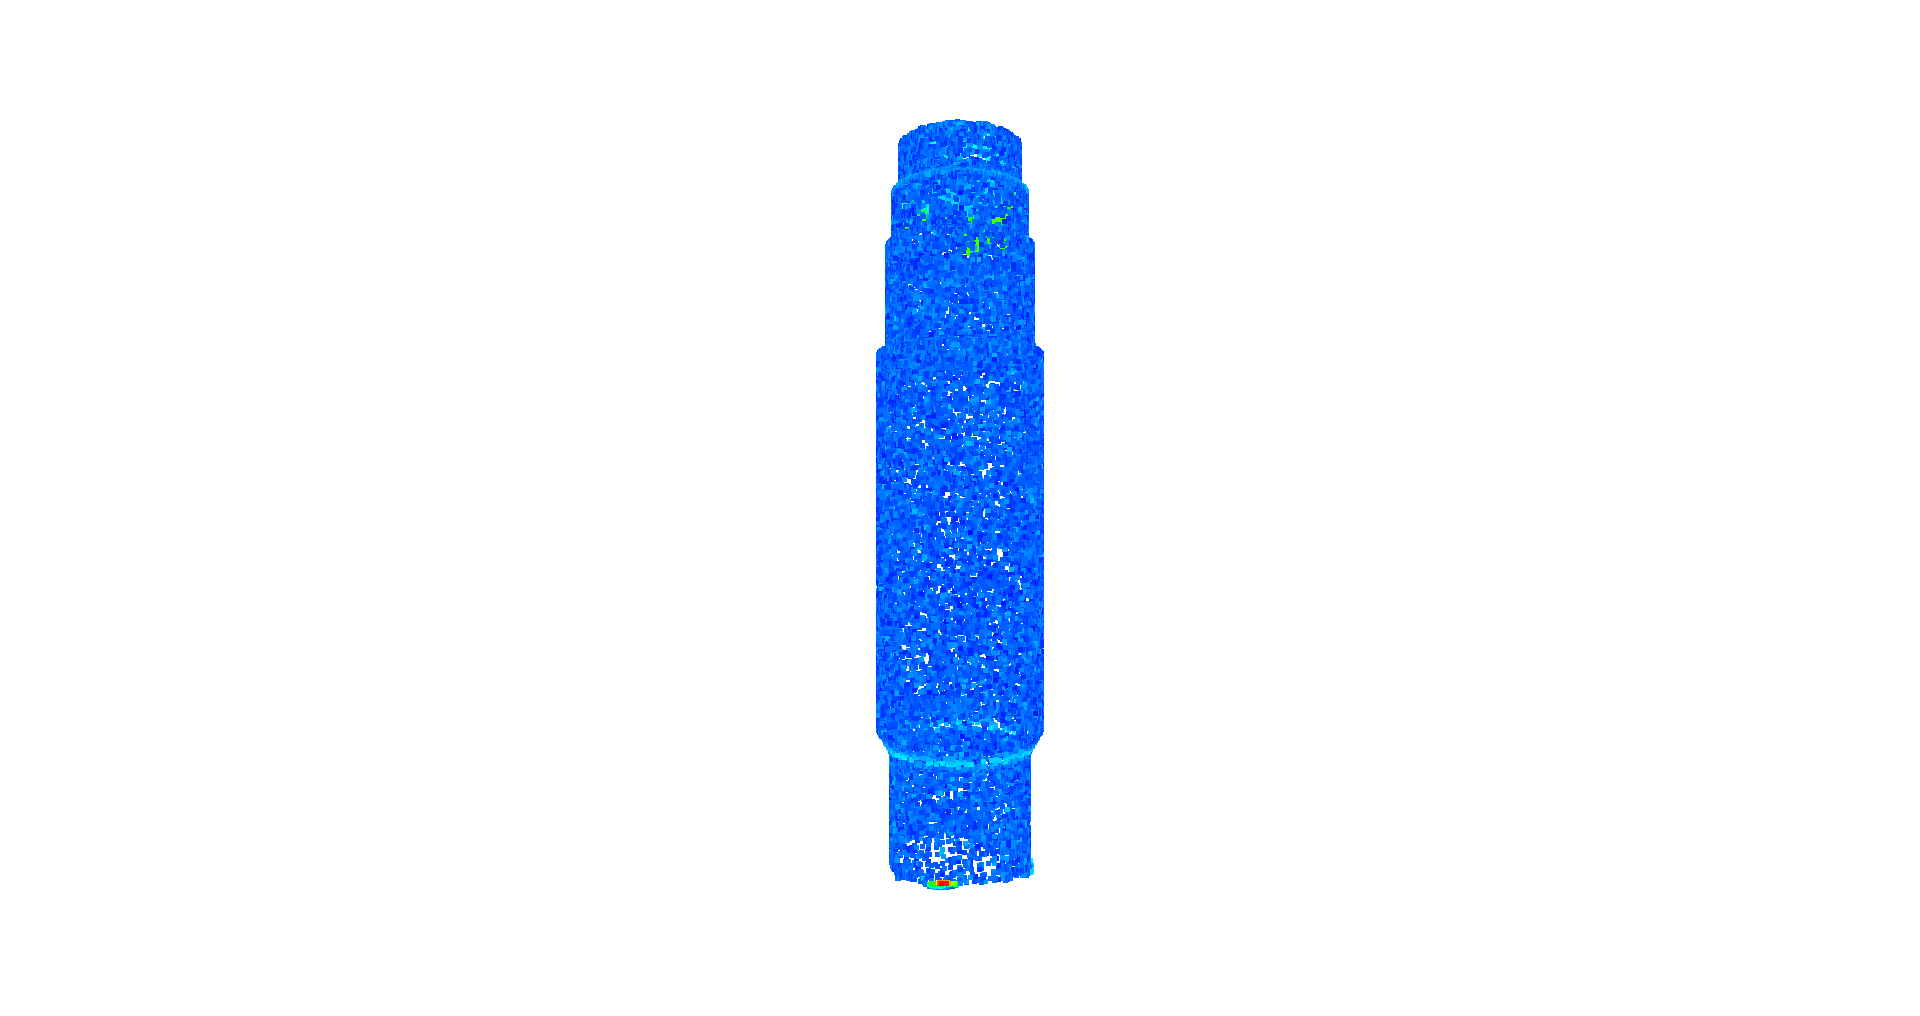

点云与stl距离


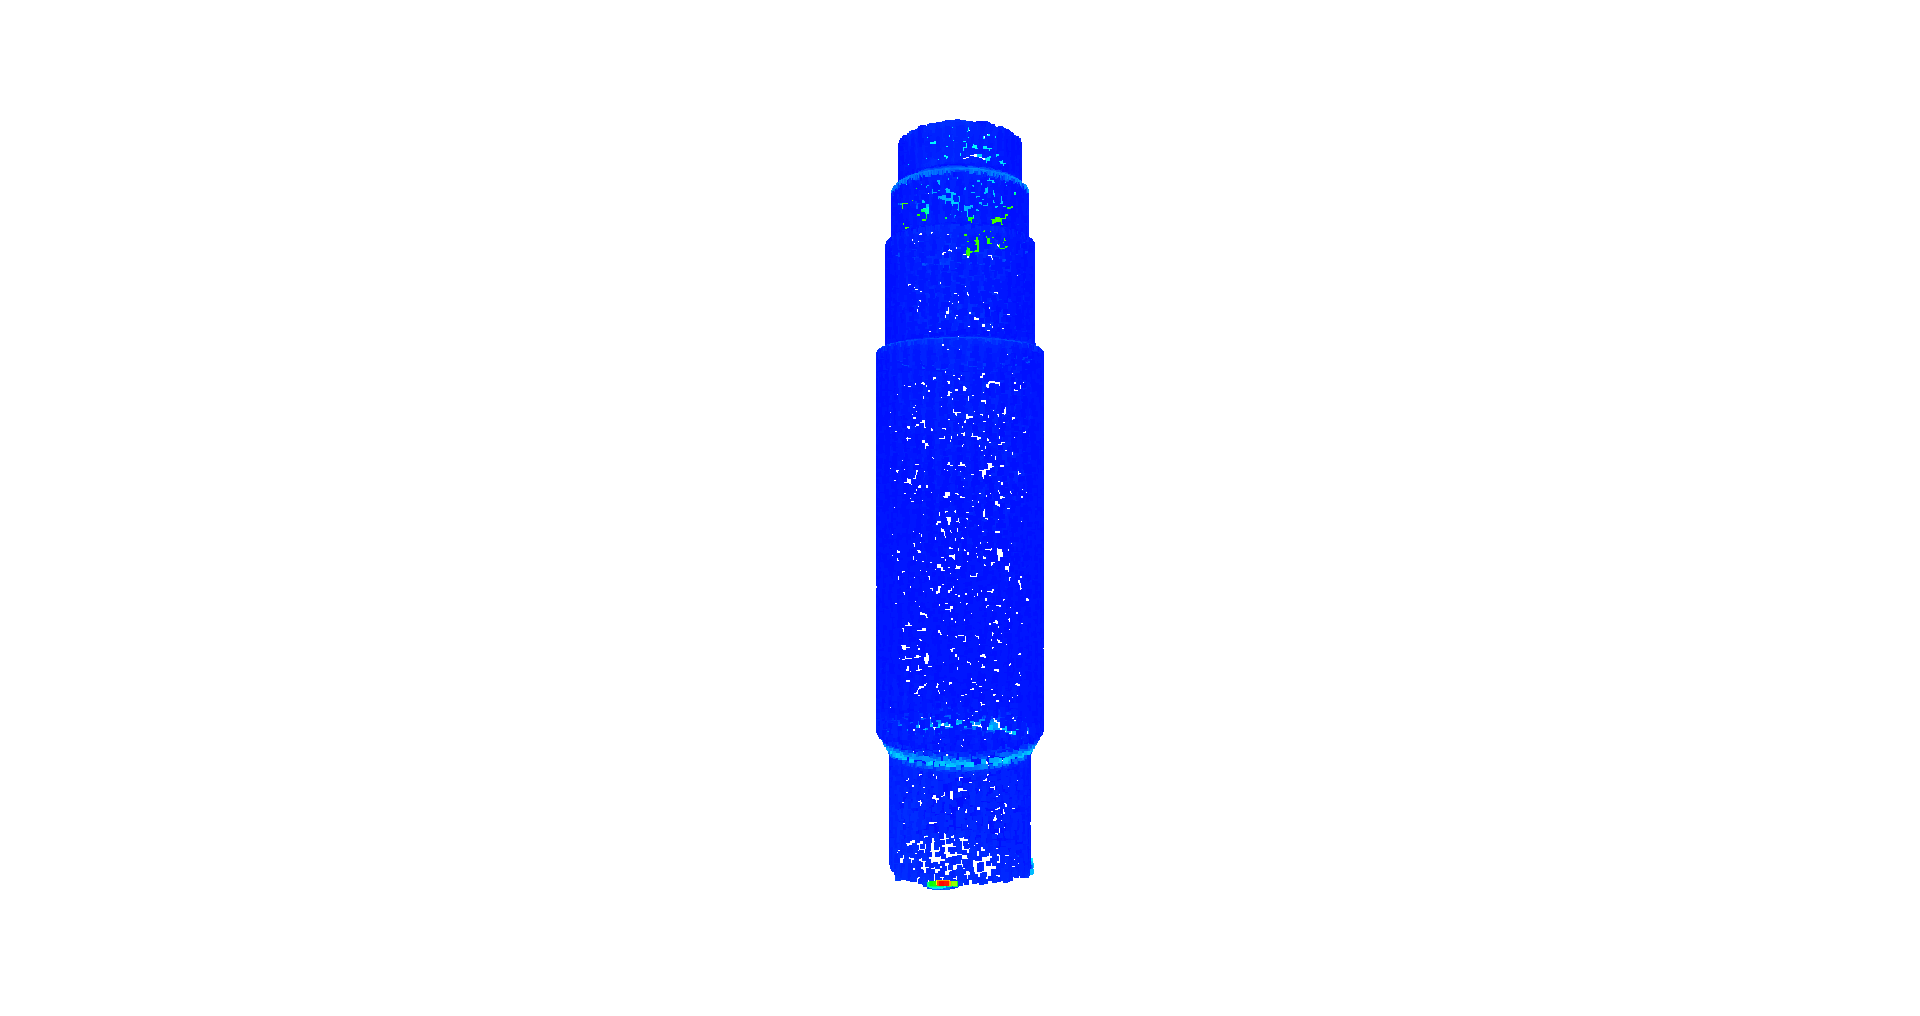

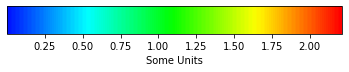

In [7]:
import matplotlib as mpl
import matplotlib.cm

hsvColor = matplotlib.cm.get_cmap('hsv')
hsvColortemp = hsvColor(np.linspace(2/3, 0, 256))   # 数值映射
GomColorBar = mpl.colors.ListedColormap(hsvColortemp)

# 归一化色彩
vmin = min([min(dists), min(distances)])
vmax = max([max(dists), max(distances)])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# 计算并显示 点云 与 stl采样点云距离
distShow = copy.deepcopy(source)
print("点云与采样点云距离")
distShow.colors = o3d.utility.Vector3dVector(GomColorBar(norm(dists))[:, :3])
o3d.visualization.draw_geometries([distShow])

# 计算并显示 点云 与 stl 距离
print("点云与stl距离")
distShow.colors = o3d.utility.Vector3dVector(GomColorBar(norm(distances))[:, :3])
o3d.visualization.draw_geometries([distShow])

import matplotlib.pyplot as plt
# 显示负号
mpl.rcParams['axes.unicode_minus']=False

def PlotColorbar(cmap, Range=[0, 1], label='Some Units'):
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    norm = mpl.colors.Normalize(vmin=Range[0], vmax=Range[1])    # 归一化显示
    Colorbar = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(Colorbar, cax=ax, orientation='horizontal', label=label)

PlotColorbar(GomColorBar, [vmin, vmax])


In [8]:
colors = GomColorBar(norm(dists))[:, :3]
pointsXYZ = np.asarray(source.points)

with open("../data/彩色pz.txt", 'w') as f:
    for p, c in zip(pointsXYZ, colors):
        f.writelines("{}, {}, {}, {}, {}, {}\n".format(p[0],p[1],p[2],c[0],c[1],c[2]))

f.close()

Normal0: 0.0 0.0 1.0
Normal0: 0.0 0.0 -1.0
Normal0: 0.4 0.0 0.9
Normal0: 0.8 0.0 0.6
Normal0: 1.0 0.0 0.2
Normal0: 1.0 0.0 -0.2
Normal0: 0.8 0.0 -0.6
Normal0: 0.4 0.0 -0.9
Normal0: 0.3 0.3 0.9
Normal0: 0.6 0.6 0.6
Normal0: 0.7 0.7 0.2
Normal0: 0.7 0.7 -0.2
Normal0: 0.6 0.6 -0.6
Normal0: 0.3 0.3 -0.9
Normal0: 0.0 0.4 0.9
Normal0: 0.0 0.8 0.6
Normal0: 0.0 1.0 0.2
Normal0: 0.0 1.0 -0.2
Normal0: 0.0 0.8 -0.6
Normal0: 0.0 0.4 -0.9
Normal0: -0.3 0.3 0.9
Normal0: -0.6 0.6 0.6
Normal0: -0.7 0.7 0.2
Normal0: -0.7 0.7 -0.2
Normal0: -0.6 0.6 -0.6
Normal0: -0.3 0.3 -0.9
Normal0: -0.4 0.0 0.9
Normal0: -0.8 0.0 0.6
Normal0: -1.0 0.0 0.2
Normal0: -1.0 0.0 -0.2
Normal0: -0.8 0.0 -0.6
Normal0: -0.4 0.0 -0.9
Normal0: -0.3 -0.3 0.9
Normal0: -0.6 -0.6 0.6
Normal0: -0.7 -0.7 0.2
Normal0: -0.7 -0.7 -0.2
Normal0: -0.6 -0.6 -0.6
Normal0: -0.3 -0.3 -0.9
Normal0: -0.0 -0.4 0.9
Normal0: -0.0 -0.8 0.6
Normal0: -0.0 -1.0 0.2
Normal0: -0.0 -1.0 -0.2
Normal0: -0.0 -0.8 -0.6
Normal0: -0.0 -0.4 -0.9
Normal0: 0.3 -0.3 

ValueError: expects 0 <= tupleIdx && tupleIdx < GetNumberOfTuples()